In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import shared_functions_wlp_wls as shared
import scipy.integrate
from halotools.empirical_models import PrebuiltHodModelFactory
import pyccl as ccl

In [2]:
SURVEY = 'SDSS'
if (SURVEY=='SDSS'):
    import params as pa
elif (SURVEY=='LSST_DESI'):
    import params_LSST_DESI as pa
else:
    print "We don't have support for that survey yet; exiting."
    exit()

Goal: compare satellite fractions for a given stellar mass bin to those given in Table 1 of Zu & Mandelbaum 2015 using both our code and the PreBuilt model in HaloTools

In [3]:
# Define a halo mass range
lgMh = np.linspace(9.0, 16.0, 100)
Mh = 10**(lgMh)

Define a series of $M_*^{\rm low}$ values such that we get the bins in Table 1

In [4]:
lgMslow = np.asarray([8.5, 9.4, 9.8, 10.2, 10.6, 11, 11.2, 11.4, 12])
Mslow = 10**(lgMslow)

Get $<N_{\rm sat}>$ and $<N_{\rm cen}>$ from our code with each of these limiting stellar masses, and then subtract appropriately to get the values in stellar mass bins.

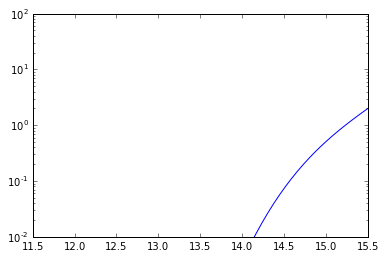

In [21]:
Nsat_us = [0]*len(Mslow); Ncen_us = [0]*len(Mslow)
for mi in range(0, len(Mslow)):
    Nsat_us[mi] = shared.get_Nsat_Zu(Mh, Mslow[mi], 'tot', 'SDSS')
    Ncen_us[mi] = shared.get_Ncen_Zu(Mh, Mslow[mi], 'SDSS')
    
plt.figure()
plt.semilogy(lgMh, Nsat_us[-1])
plt.ylim(0.01, 100)
plt.xlim(11.5, 15.5)
plt.show()
    
Nsat_bin_us = [0] * (len(Mslow)-1); Ncen_bin_us = [0] * (len(Mslow)-1)
for mi in range(0,len(Mslow)-1):
    Nsat_bin_us[mi] = Nsat_us[mi] - Nsat_us[mi+1]
    Ncen_bin_us[mi] = Ncen_us[mi] - Ncen_us[mi+1]

Set up and get the same from halotools

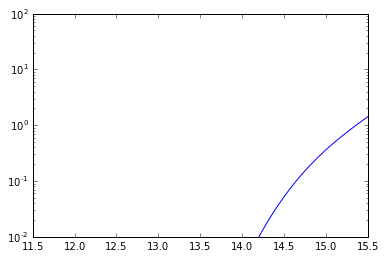

In [22]:
Nsat_HT = [0]*len(Mslow); Ncen_HT = [0]*len(Mslow);
for mi in range(0,len(Mslow)):
    model = PrebuiltHodModelFactory('zu_mandelbaum15', threshold = lgMslow[mi], prim_haloprop_key = 'halo_m200m')
    Nsat_HT[mi] = model.mean_occupation_satellites(prim_haloprop=Mh)
    Ncen_HT[mi] = model.mean_occupation_centrals(prim_haloprop=Mh)
    
Nsat_bin_HT = [0] * (len(Mslow)-1); Ncen_bin_HT = [0] * (len(Mslow)-1)
for mi in range(0,len(Mslow)-1):
    Nsat_bin_HT[mi] = Nsat_HT[mi] - Nsat_HT[mi+1]
    Ncen_bin_HT[mi] = Ncen_HT[mi] - Ncen_HT[mi+1]
    
plt.figure()
plt.semilogy(lgMh, Nsat_HT[-1])
plt.ylim(0.01, 100)
plt.xlim(11.5, 15.5)
plt.show()

Get the Tinker Halomass function from CCL at the appropriate redshifts for comparison.

In [15]:
#Initialize the cosmology
p = ccl.Parameters(Omega_c = pa.OmC_s, Omega_b = pa.OmB_s, h = (pa.HH0_s/100.), sigma8=pa.sigma8_s, n_s=pa.n_s_s)
cosmo = ccl.Cosmology(p)

z_bin = np.asarray([0.02, 0.04, 0.06, 0.08, 0.1, 0.15, 0.17, 0.19])
HMF = [0]*len(z_bin)
for zi in range(0,len(HMF)):
    HMF[zi]= ccl.massfunction.massfunc(cosmo, Mh / (pa.HH0_s/100.), 1./ (1. + z_bin[zi]), odelta=200.) / (pa.HH0_s/100.)**3

Integrate over the halo mass function to get the satellite fraction in each bin in both cases.

In [17]:
fsat_us = np.zeros(len(z_bin)); fsat_HT = np.zeros(len(z_bin))
for i in range(0,len(z_bin)):
    nsat_tot_us = scipy.integrate.simps(HMF[i] * Nsat_bin_us[i], np.log10(Mh/(pa.HH0_s/100.)))
    ncen_tot_us = scipy.integrate.simps(HMF[i] * Ncen_bin_us[i], np.log10(Mh/(pa.HH0_s/100.)))
    ntot_us = nsat_tot_us + ncen_tot_us
    fsat_us[i] = nsat_tot_us / ntot_us
    
    nsat_tot_HT = scipy.integrate.simps(HMF[i] * Nsat_bin_HT[i], np.log10(Mh/(pa.HH0_s/100.)))
    ncen_tot_HT = scipy.integrate.simps(HMF[i] * Ncen_bin_HT[i], np.log10(Mh/(pa.HH0_s/100.)))
    ntot_HT = nsat_tot_HT + ncen_tot_HT
    fsat_HT[i] = nsat_tot_HT / ntot_HT

What happens if I look at the satelite fraction in both cases for the thresholded bin at 9.8, roughly the SDSS sample?

In [29]:
 HMF_SDSS= ccl.massfunction.massfunc(cosmo, Mh / (pa.HH0_s/100.), 1./ (1. + 0.28), odelta=200.) / (pa.HH0_s/100.)**3

nsat_SDSS_us = scipy.integrate.simps(HMF_SDSS * Nsat_us[2], np.log10(Mh / (pa.HH0_s / 100.)))
ncen_SDSS_us = scipy.integrate.simps(HMF_SDSS * Ncen_us[2], np.log10(Mh / (pa.HH0_s / 100.)))

print "fsat, SDSS us=", nsat_SDSS_us / (ncen_SDSS_us + nsat_SDSS_us)

nsat_SDSS_HT = scipy.integrate.simps(HMF_SDSS * Nsat_HT[2], np.log10(Mh / (pa.HH0_s / 100.)))
ncen_SDSS_HT = scipy.integrate.simps(HMF_SDSS * Ncen_HT[2], np.log10(Mh / (pa.HH0_s / 100.)))

print "fsat, SDSS HT=", nsat_SDSS_HT / (ncen_SDSS_HT + nsat_SDSS_HT)

fsat, SDSS us= 0.508565506593
fsat, SDSS HT= 0.332190257066


output these values

In [18]:
for i in range(0, len(z_bin)):
    print "M=", lgMslow[i], "-", lgMslow[i+1], " fsat us=", fsat_us[i], "fsat HT=", fsat_HT[i]

M= 8.5 - 9.4  fsat us= 0.621238261325 fsat HT= 0.00623306756781
M= 9.4 - 9.8  fsat us= 0.630025212506 fsat HT= 0.390284056261
M= 9.8 - 10.2  fsat us= 0.612449767253 fsat HT= 0.389858729725
M= 10.2 - 10.6  fsat us= 0.550548731105 fsat HT= 0.373017985063
M= 10.6 - 11.0  fsat us= 0.425363218604 fsat HT= 0.329791809627
M= 11.0 - 11.2  fsat us= 0.28090789263 fsat HT= 0.284657673595
M= 11.2 - 11.4  fsat us= 0.202736521275 fsat HT= 0.256309622356
M= 11.4 - 12.0  fsat us= 0.135776891882 fsat HT= 0.20587168957
